### Analyze correlation between T and AOU

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean as cmo
import gsw

In [5]:
ddir = '/swot/SUM05/dbalwada/BSOSE/'

In [6]:
# Open BSOSE data
ds_O2 = xr.open_dataset(ddir+ 'bsose_Iter135_2013to2019_5day_O2.nc')
ds_T  = xr.open_dataset(ddir+ 'bsose_Iter135_2013to2019_5day_Theta.nc')
ds_S  = xr.open_dataset(ddir+ 'bsose_Iter135_2013to2019_5day_Salt.nc')

In [9]:
ds_T

<xarray.Dataset>
Dimensions:    (XC: 2160, YC: 588, Z: 52, time: 511)
Coordinates:
    iter       (time) int64 ...
  * time       (time) datetime64[ns] 2013-01-05 2013-01-10 ... 2019-12-30
  * XC         (XC) float32 0.08333 0.25 0.4167 0.5833 ... 359.6 359.8 359.9
  * YC         (YC) float32 -77.98 -77.95 -77.91 -77.88 ... -30.02 -29.87 -29.72
  * Z          (Z) float32 -2.1 -6.7 -12.15 -18.55 ... -5e+03 -5.4e+03 -5.8e+03
    rA         (YC, XC) float32 ...
    Depth      (YC, XC) float32 ...
    drF        (Z) float32 ...
    hFacC      (Z, YC, XC) float32 ...
    maskC      (Z, YC, XC) bool ...
    maskCtrlC  (Z, YC, XC) bool ...
    rhoRef     (Z) float32 ...
    rLowC      (YC, XC) float32 ...
    maskInC    (YC, XC) bool ...
    rSurfC     (YC, XC) float32 ...
Data variables:
    THETA      (time, Z, YC, XC) float32 ...

In [17]:
# Do some chunking of the data to make things go faster
# I am not sure how much this actually helps, will have to do some analysis of 
# dask to know for sure. 
OXY = ds_O2.TRAC03.chunk({'YC':42, 'XC':40})
TEMP = ds_T.THETA.chunk({'YC':42, 'XC':40})
SALT = ds_S.SALT.chunk({'YC':42, 'XC':40,})

### Make some plots to see patterns

In [38]:
# select small subset for plotting
TEMP_X30 = TEMP.isel(time=0).sel(XC=30, method='nearest')
SALT_X30 = SALT.isel(time=0).sel(XC=30, method='nearest')
OXY_X30 = OXY.isel(time=0).sel(XC=30, method='nearest')

In [39]:
O2_sol_X30 = gsw.O2sol_SP_pt(SALT_X30, TEMP_X30)

In [40]:
AOU_X30 = OXY_X30*1/.0010245 - O2_sol_X30 ## The multiplication factor is to do unit conversion
AOU_X30.load(); # load data to make plotting faster

In [ ]:
TEMP_X30.load();

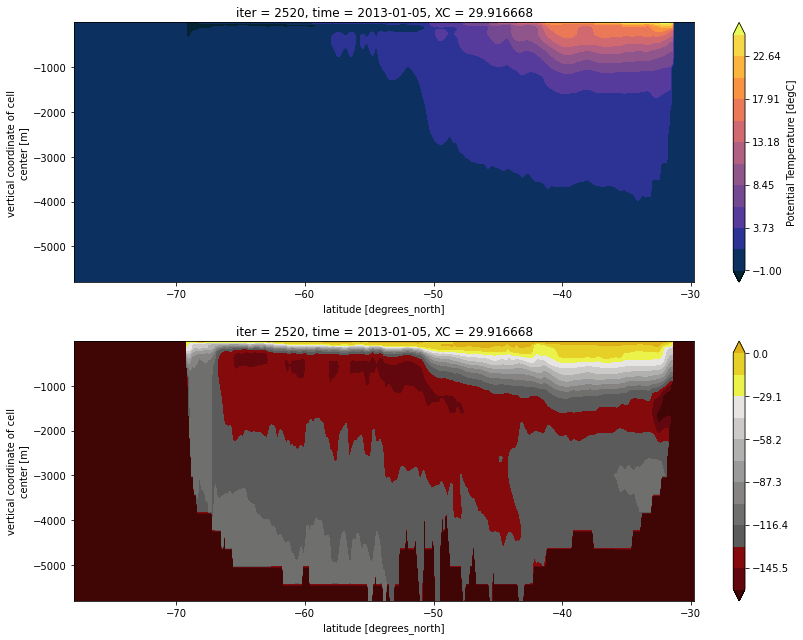

In [49]:
plt.figure(figsize=(12,9))
plt.subplot(211)
TEMP_X30.plot.contourf(levels= np.linspace(-1,25,12),vmin=-1, vmax=25,  cmap=cmo.cm.thermal)

plt.subplot(212)
AOU_X30.plot.contourf(levels= np.linspace(-160,0,12),vmax=0, vmin=-160, cmap=cmo.cm.oxy)

plt.tight_layout()
# section plots of PT and AOU, looks about right.

### Make some plots at a single depth

In [50]:
depth = -100

In [51]:
TEMP_depth = TEMP.isel(time=0).sel(Z=depth, method='nearest')
SALT_depth = SALT.isel(time=0).sel(Z=depth, method='nearest')
OXY_depth = OXY.isel(time=0).sel(Z=depth, method='nearest')

In [52]:
O2_sol_depth = gsw.O2sol_SP_pt(SALT_depth, TEMP_depth)

In [29]:
AOU_depth = OXY_depth*1/.0010245 - O2_sol_depth
AOU_depth.load();

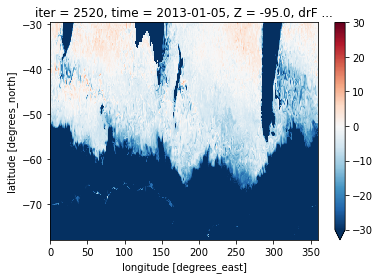

In [35]:
AOU_depth.plot(vmin=-30)

## Correlation estimation

In [ ]:
depth = -100 # select single depth to do the analysis on initially (to make sure computer does not die with data)

In [55]:
TEMP_100m = TEMP.sel(Z=depth, method='nearest') # selecting one depth, but all times
SALT_100m = SALT.sel(Z=depth, method='nearest')
OXY_100m = OXY.sel(Z=depth, method='nearest')

In [56]:
O2_sol_100m = gsw.O2sol_SP_pt(SALT_100m, TEMP_100m)

In [57]:
AOU_100m = OXY_100m*1/.0010245 - O2_sol_100m

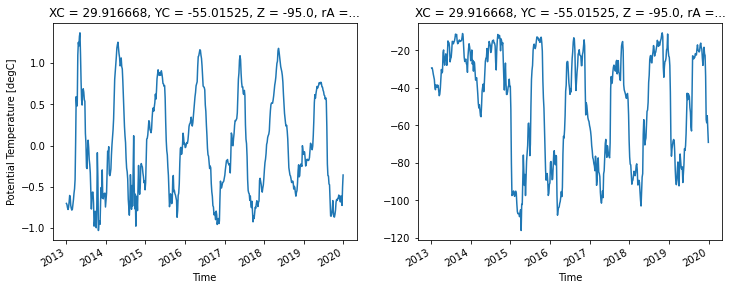

In [58]:
plt.figure(figsize=(12,4))
plt.subplot(121)
TEMP_100m.sel(XC=30, YC=-55, method='nearest').plot()

plt.subplot(122)
AOU_100m.sel(XC=30, YC=-55, method='nearest').plot()

In [60]:
# Estimate data trend as a 1 year running mean. BSOSE has a major trend, specially for first few year at depths below ML
TEMP_100m_trend = TEMP_100m.rolling(time=72, center=True).mean('time')
AOU_100m_trend = AOU_100m.rolling(time=72, center=True).mean('time')

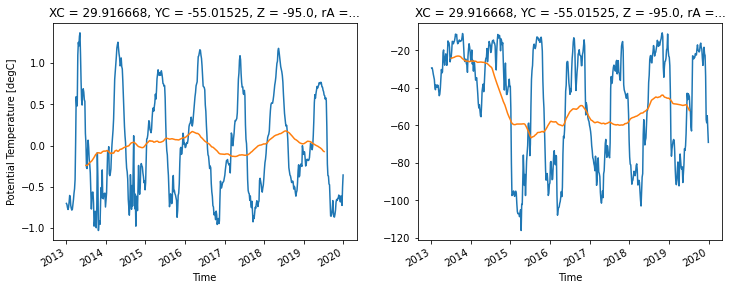

In [61]:
plt.figure(figsize=(12,4))
plt.subplot(121)
TEMP_100m.sel(XC=30, YC=-55, method='nearest').plot()
TEMP_100m_trend.sel(XC=30, YC=-55, method='nearest').plot()

plt.subplot(122)
AOU_100m.sel(XC=30, YC=-55, method='nearest').plot()
AOU_100m_trend.sel(XC=30, YC=-55, method='nearest').plot()

In [62]:
# detrend data
TEMP_detrend = TEMP_100m - TEMP_100m_trend
AOU_detrend = AOU_100m - AOU_100m_trend

In [66]:
# Remove spatial mean and monthly climatology
# to make this faster we can probably use coarsen instead of rolling, but will need to figure out how to estimate
# anomalies with coarsen. 
gb = TEMP_detrend.rolling(XC=30, YC=30, center=True).mean().groupby('time.month')
T_clim_sm = gb.mean(dim='time')
T_clim_sm_anom = gb - T_clim_sm

In [67]:
gb = AOU_detrend.rolling(XC=30, YC=30, center=True).mean().groupby('time.month')
AOU_clim_sm = gb.mean(dim='time')
AOU_clim_sm_anom = gb - AOU_clim_sm

/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


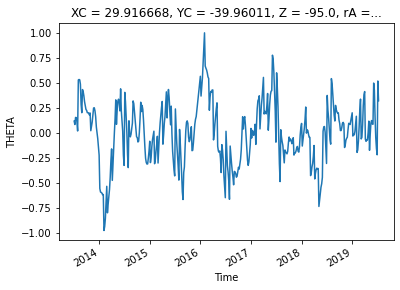

In [70]:
T_clim_sm_anom.sel(XC=30, YC=-40, method='nearest').plot()

/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


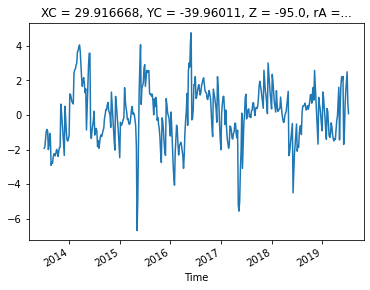

In [71]:
AOU_clim_sm_anom.sel(XC=30, YC=-40, method='nearest').plot()

In [74]:
Tvals = T_clim_sm_anom.sel(XC=30, YC=-40, method='nearest').values
AOUvals = AOU_clim_sm_anom.sel(XC=30, YC=-40, method='nearest').values

/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


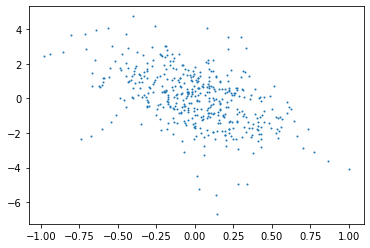

In [75]:
# scatter plot shows some  correlation
plt.scatter(Tvals, 
            AOUvals , s =1)

In [76]:
# estimate correlation coefficient
T_var = (T_clim_sm_anom**2).mean('time')
AOU_var = (AOU_clim_sm_anom**2).mean('time')
T_AOU_covar = (T_clim_sm_anom*AOU_clim_sm_anom).mean('time')
corr_coeff = T_AOU_covar / T_var**0.5 / AOU_var**0.5

In [ ]:
corr_coeff.load(); # this takes the most time

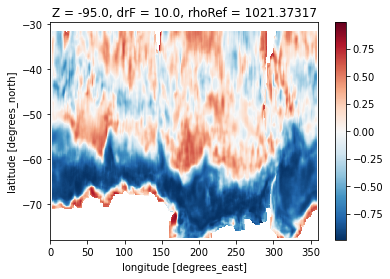

In [80]:
corr_coeff.plot()

Text(0.5, 1.0, 'Corr coeff T and AOU 100m')

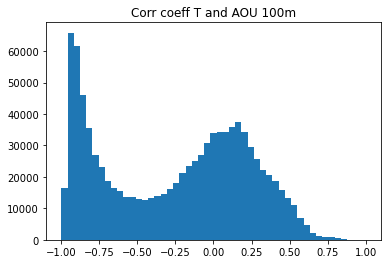

In [81]:
corr_coeff.plot.hist(bins=np.linspace(-1,1,50));
plt.title('Corr coeff T and AOU 100m')

### Estimate correlation at another depth
Exact same procedure as above. Can be made more systematic instead of doing it in this repetetive copy paste way.

In [112]:
depth = -600

In [113]:
TEMP_300m = TEMP.sel(Z=depth, method='nearest') # note that variable names are not correct
SALT_300m = SALT.sel(Z=depth, method='nearest')
OXY_300m = OXY.sel(Z=depth, method='nearest')

In [114]:
O2_sol_300m = gsw.O2sol_SP_pt(SALT_300m, TEMP_300m)

In [115]:
AOU_300m = OXY_300m*1/.0010245 - O2_sol_300m

In [116]:
# Detrend
TEMP_300m_trend = TEMP_300m.rolling(time=72, center=True).mean('time')
AOU_300m_trend  = AOU_300m.rolling(time=72, center=True).mean('time')

In [117]:
TEMP_detrend = TEMP_300m - TEMP_300m_trend
AOU_detrend = AOU_300m - AOU_300m_trend

In [118]:
gb = TEMP_detrend.rolling(XC=30, YC=30, center=True).mean().groupby('time.month')
T_clim_sm = gb.mean(dim='time')
T_clim_sm_anom = gb - T_clim_sm

In [119]:
gb = AOU_detrend.rolling(XC=30, YC=30, center=True).mean().groupby('time.month')
AOU_clim_sm = gb.mean(dim='time')
AOU_clim_sm_anom = gb - AOU_clim_sm

/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


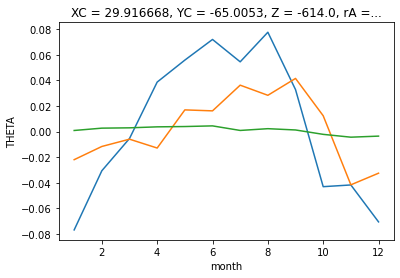

In [120]:
# make some plots to see what climatologies etc look like
T_clim_sm.sel(XC=30, YC=-40, method='nearest').plot()
T_clim_sm.sel(XC=30, YC=-50, method='nearest').plot()
T_clim_sm.sel(XC=30, YC=-65, method='nearest').plot()

/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


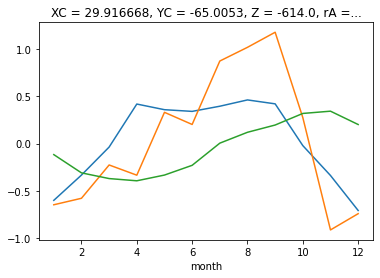

In [124]:
AOU_clim_sm.sel(XC=30, YC=-40, method='nearest').plot()
AOU_clim_sm.sel(XC=30, YC=-50, method='nearest').plot()
AOU_clim_sm.sel(XC=30, YC=-65, method='nearest').plot()

/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


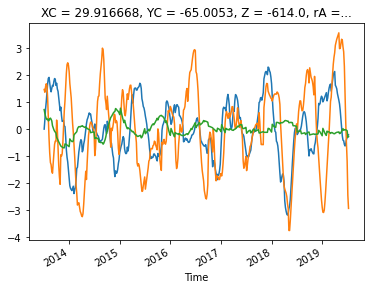

In [123]:
AOU_clim_sm_anom.sel(XC=30, YC=-40, method='nearest').plot()
AOU_clim_sm_anom.sel(XC=30, YC=-50, method='nearest').plot()
AOU_clim_sm_anom.sel(XC=30, YC=-65, method='nearest').plot()

In [125]:
T_var = (T_clim_sm_anom**2).mean('time')
AOU_var = (AOU_clim_sm_anom**2).mean('time')
T_AOU_covar = (T_clim_sm_anom*AOU_clim_sm_anom).mean('time')
corr_coeff_600m = T_AOU_covar / T_var**0.5 / AOU_var**0.5

In [ ]:
corr_coeff_600m.load();

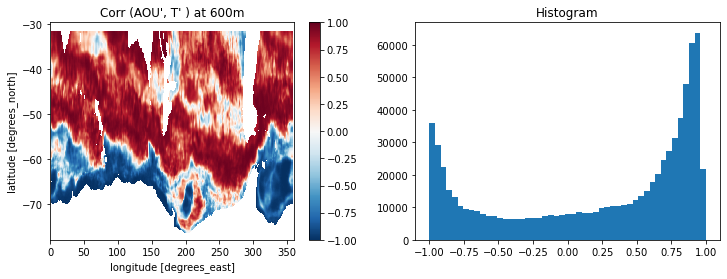

In [129]:
plt.figure(figsize=(12,4))

plt.subplot(121)
corr_coeff_600m.where(corr_coeff_600m.Depth>2000).plot(vmin=-1)
plt.title('Corr (AOU\', T\' ) at 600m')

plt.subplot(122)
corr_coeff_600m.where(corr_coeff_600m.Depth>2000).plot.hist(bins=np.linspace(-1,1,50));
